<a href="https://colab.research.google.com/github/ankitaggarwal64/Agricultural-Equipment-Sales-Forecasting/blob/main/Univariate_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#import sales and indices combined data
combined_sales_ind = pd.read_csv("/content/drive/My Drive/1. Data Science/Sales Forecasting_Masters Project/Masters Project/Data/Output_files/combined_sales_ind.csv",parse_dates=['Time'], index_col='Time')

In [4]:
# Univariate Sales data
sales = combined_sales_ind["Sales"]

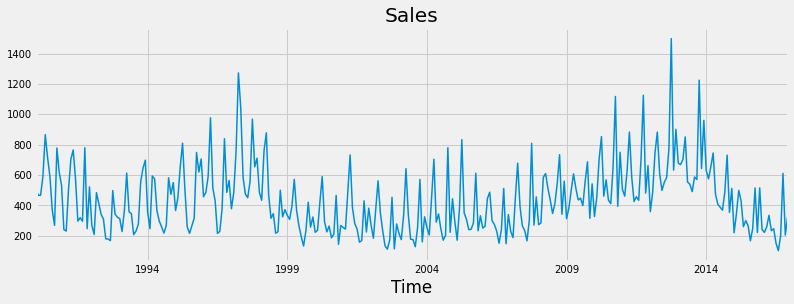

In [5]:
# Line plot of Sales time series
plt.style.use("fivethirtyeight")
ax = sales.plot(subplots= False,linewidth=1.5,sharex=False,sharey=False, figsize=(12,4),fontsize=10)
plt.title("Sales")
plt.show()

## Obseravtion : There is clear cyclicity and seasonality

**Train and Test Split:**

*   Train data : 1990 to 2012
*   Test data : 2013 to 2016 (4 Years)





In [7]:
# Train and Test Split
split_point = len(sales)-48 #Upto Dec-2012
train,test = sales[0:split_point],sales[split_point:]
print('Train %d, Test %d' % (len(train),len(test)))

Train 276, Test 48


**Model Paramater Estimation:**

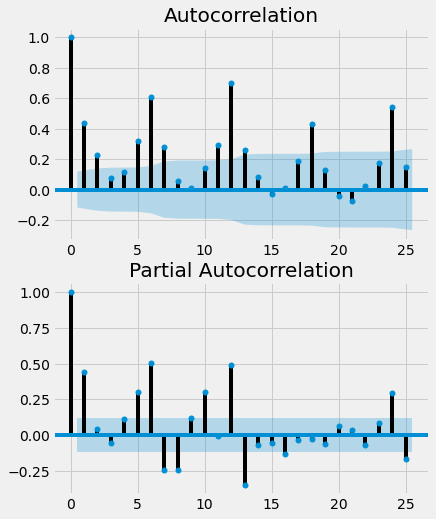

In [8]:
#Plot ACF and PACF
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
import pylab
pylab.rcParams['figure.figsize'] = (6,8)
pyplot.figure()
pyplot.subplot(211)
plot_acf(train, lags=25, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(train, lags=25, ax=pyplot.gca())
pyplot.show()

#OBSERVATIONS:
#There is a clear seasonality of 12 as seen in the peaks of ACF plot
#There is a possibility of both AR and MA terms because of geometric decay on ACF plot and significant autocorrelation of particular lags on PACF plot

In [9]:
# Define the p, d and q parameters possible values
p = range(0, 3)
d = range(0, 2)
q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
# specify to ignore warning messages
warnings.filterwarnings("ignore") 

# Grid Cross validation for best parameters estimation
columns = ['param','param_seasonal','aic']
rows = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            row = [param, param_seasonal, results.aic]
            rows.append(row)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

models_aic = pd.DataFrame(rows, columns=columns)

In [175]:
models_aic.sort_values(by=["aic"])

,param,param_seasonal,aic
143,"(2, 1, 1)","(2, 1, 1, 12)",2861.769416
95,"(1, 1, 1)","(2, 1, 1, 12)",2870.866942
119,"(2, 0, 1)","(2, 1, 1, 12)",2871.902635
142,"(2, 1, 1)","(2, 1, 0, 12)",2873.302778
131,"(2, 1, 0)","(2, 1, 1, 12)",2874.105710
...,...,...,...
24,"(0, 1, 0)","(0, 0, 0, 12)",3762.090610
48,"(1, 0, 0)","(0, 0, 0, 12)",3762.140924
1,"(0, 0, 0)","(0, 0, 1, 12)",3788.018424
12,"(0, 0, 1)","(0, 0, 0, 12)",3988.694081


**Model Training:**

In [10]:
#Intantiate the model with best Model Paramter
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

# Fit training
results = mod.fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [11]:
# Model Summary Statistics
print(results.summary())

# Obseration : High probability of Ljung-Box repesents lack of autocorrelation 

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  276
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1423.885
Date:                            Sat, 28 Nov 2020   AIC                           2861.769
Time:                                    04:35:57   BIC                           2886.046
Sample:                                01-31-1990   HQIC                          2871.554
                                     - 12-31-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2550      0.104      2.440      0.015       0.050       0.460
ar.L2         -0.0083      0.095   

In [12]:
# Checking Residual Summary Statistics
results.resid.describe()

# Obseration : Residual mean is near to zero.

count    276.000000
mean       2.847369
std      128.325376
min     -627.959131
25%      -66.996507
50%        3.849638
75%       59.061726
max      524.667774
dtype: float64

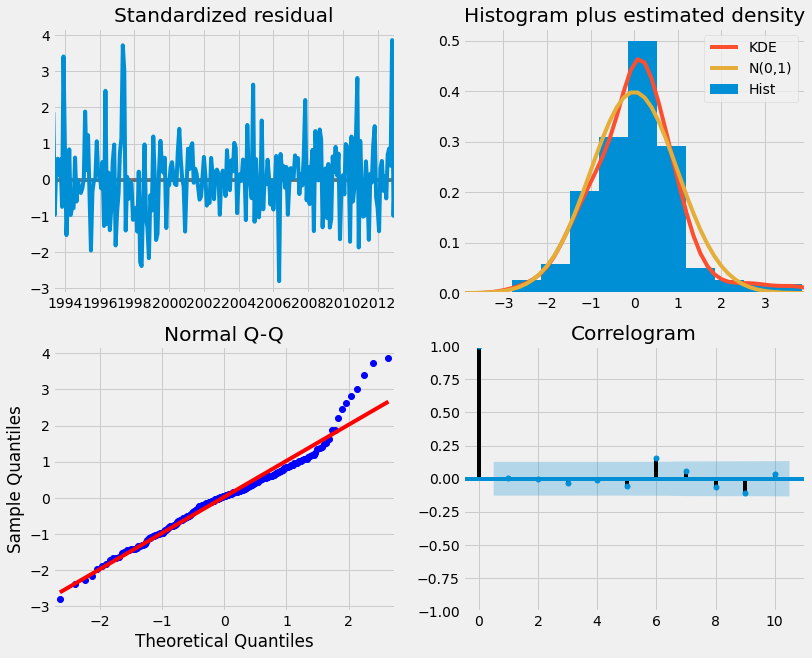

In [13]:
# Residual diagnostics
results.plot_diagnostics(figsize=(12, 10))
plt.show()

# Obervation: Based on plots, residuls seems to be close to white noise, normally distributed and does not seems to have any significant autocorrelation

**Walk Forward Validation:**

In [17]:
# Walk Forward validation
min_train = len(train)-6*12 # upto Dec-2006
sliding_window = 12

In [18]:
# Creating list to store model validation metrics during walk forward validation
columns_val = ['Rmse', 'Bias', 'MAPE']
rows_val = []

In [20]:
# Calculating  evaluation metrics during walk forward validation
for i in range(0,(5*12)):
  start= min_train+i
  end = min_train+i+(12-1)
  pred_dynamic = results.get_prediction(start= start, end = end , dynamic=True)
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Extract the predicted and true values of our time series
  y_val_forecasted = pred_dynamic.predicted_mean
  y_val_truth = train[start:end+1]

  # Compute the Root mean squared error
  from sklearn.metrics import mean_squared_error
  from math import sqrt
  rmse = sqrt(mean_squared_error(y_val_truth, y_val_forecasted))

  # Compute Bias
  forecast_errors = y_val_truth - y_val_forecasted
  bias = sum(forecast_errors)*1.0/len(forecast_errors)

  # Compute MAPE
  percent_forecast_errors = abs(y_val_truth - y_val_forecasted)*100/y_val_truth 
  MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

  row = [rmse, bias, MAPE]
  rows_val.append(row)

In [22]:
# Validation Error & Metrics from 2007 to 2012 with 12 months sliding forecast window
val_metrics = pd.DataFrame(rows_val, columns=columns_val)
print(val_metrics.mean())

Rmse    104.468030
Bias     21.614327
MAPE     15.979144
dtype: float64


**Model Testing with Batch Training**

In [23]:
# Walk Forward Model testing
min_train = len(train) # upto Dec-2012
sliding_window = 12

In [24]:
# Creating list to store model test metrics
rows_test = []
columns_test = ['Rmse', 'Bias', 'MAPE' , 'Residual_stdev' , 'Avg_pred_interval']

In [25]:
# Calculating evaluation metrics during walk forward testing
for i in range(0,3*12):
  start= min_train+i
  end = min_train+i+(12-1)

  # specify to ignore warning messages
  warnings.filterwarnings("ignore") 

  #Intantiate the model (with Batch Training)
  mod = sm.tsa.statespace.SARIMAX(sales[:start],
                                order=(2, 1, 1),
                                seasonal_order=(2, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

  # Fit training
  results = mod.fit()

  # Get forecast 12 steps ahead in future
  pred_dynamic = results.get_forecast(steps=12)

  # Get confidence intervals of forecasts
  pred_dynamic_ci = pred_dynamic.conf_int()

  # Extract the predicted and true values of our time series
  y_val_forecasted = pred_dynamic.predicted_mean
  y_val_truth = test[i:i+12]

  # report performance

  # Compute the Root mean squared error
  from sklearn.metrics import mean_squared_error
  from math import sqrt
  rmse = sqrt(mean_squared_error(y_val_truth, y_val_forecasted))

  # Compute Bias
  forecast_errors = y_val_truth - y_val_forecasted
  bias = sum(forecast_errors)*1.0/len(forecast_errors)

  # Compute MAPE
  percent_forecast_errors = abs(y_val_truth - y_val_forecasted)*100/y_val_truth 
  MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)

  #Residual Standard Deviation (Measure of Uncertanity of forecasting)
  Residual_stdev = results.resid.describe()["std"]

  #Avergae Prediction Interval (95%)(Measure of Uncertanity of forecasting)
  Avg_pred_interval = (pred_dynamic_ci["upper Sales"]- pred_dynamic_ci["lower Sales"]).mean()

  row = [rmse, bias, MAPE,Residual_stdev,Avg_pred_interval]
  rows_test.append(row)

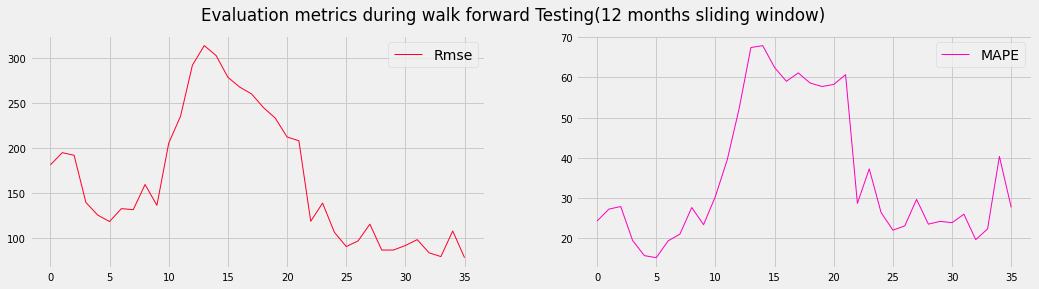

In [42]:
# Plotting Evaluation metrics - RMSE & MAPE during walk forward Testing with 12months period
plt.style.use("fivethirtyeight")
ax = test_metrics[["Rmse","MAPE"]].plot(subplots=True, title ="Evaluation metrics during walk forward Testing(12 months sliding window)",linewidth=1,layout =(1,2),sharex=False,sharey=False,colormap = "gist_rainbow", figsize=(16,4),fontsize=10)
plt.show()


In [43]:
# Average Test Evaluation Metrics from 2013 to 2016 with 12 months sliding forecast window
test_metrics = pd.DataFrame(rows_test, columns=columns_test)
print(test_metrics.mean())

Rmse                 165.003987
Bias                -110.316109
MAPE                  35.292770
Residual_stdev       128.281487
Avg_pred_interval    511.264422
dtype: float64


In [ ]:
#####

In [99]:
# Model Testing
# Get forecast 12 steps ahead in future(2016)
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

In [100]:
pred_uc.predicted_mean

2014-01-31     661.962687
2014-02-28     674.944382
2014-03-31     821.208205
2014-04-30     976.602891
2014-05-31     695.203324
2014-06-30     635.643651
2014-07-31     615.004410
2014-08-31     646.426478
2014-09-30     755.247900
2014-10-31    1307.981070
2014-11-30     681.359220
2014-12-31     947.077708
Freq: M, dtype: float64

In [ ]:
# Extract the predicted and true values of our time series
y_forecasted = pred_uc.predicted_mean
y_truth = test

# report performance
# Compute the Root mean squared error
rmse = sqrt(mean_squared_error(y_truth, y_forecasted))
print('RMSE: %.3f' % rmse)

forecast_errors = y_truth-y_forecasted
bias = sum(forecast_errors)*1.0/len(forecast_errors)
print('Bias: %.3f' % bias)

percent_forecast_errors = abs(y_truth-y_forecasted)*100/y_truth 
MAPE = sum(percent_forecast_errors)*1.0/len(percent_forecast_errors)
print('MAPE: %.3f' % MAPE)

#Residual Standard Deviation (Measure of Uncertanity of forecasting)
Residual_stdev = results.resid.describe()["std"]

print('Residual Stdev: %.3f' % Residual_stdev)

#Avergae Prediction Interval (95%)(Measure of Uncertanity of forecasting)
Avg_pred_interval = (pred_ci["upper Sales"]- pred_ci["lower Sales"]).mean()
print('Average Prediction Interval: %.3f' % Avg_pred_interval)

RMSE: 60.307
Bias: -9.256
MAPE: 17.927
Residual Stdev: 127.529
Average Prediction Interval: 526.791


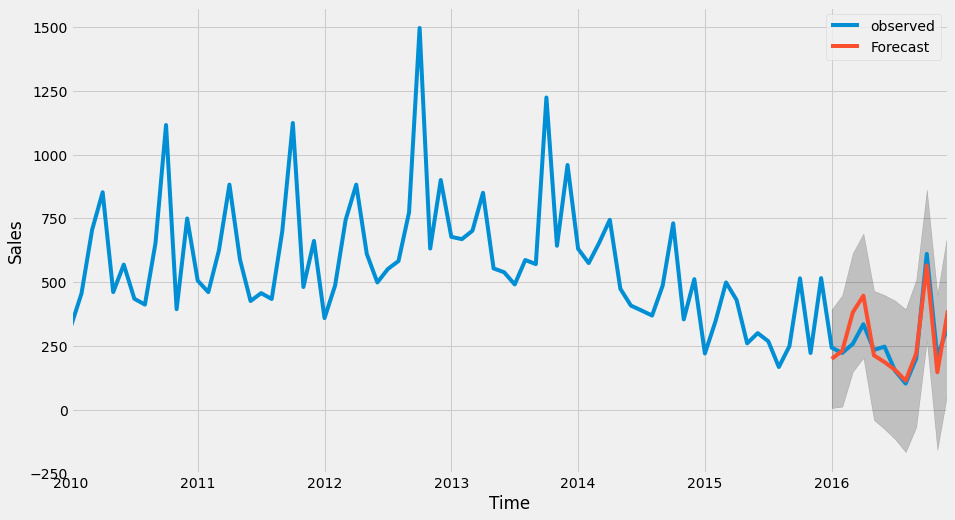

In [ ]:
#Plot Model Forecast during Test Period
ax = sales['2010':].plot(label='observed', figsize=(14, 8))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=0.20)
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

plt.legend()
plt.show()